In [3]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Pipeline
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
user_profiles = pd.read_csv(r'data/user_profiles.csv')
user_profiles.head()

,user_id,age,gender,height_cm,weight_kg,BMI,activity_level,blood_pressure,cholesterol_level,calorie_intake,diet_plan
0,1,32,Female,143,114,55.7,Lightly Active,156/100,High,1519,Low-Fat Diet
1,2,43,Male,140,100,51.0,Lightly Active,150/97,High,2721,Low-Fat Diet
2,3,37,Female,174,98,32.4,Very Active,142/95,Borderline,1987,Keto Diet
3,4,35,Female,194,128,34.0,Lightly Active,150/95,High,1579,Low-Fat Diet
4,5,66,Male,169,71,24.9,Very Active,158/92,Normal,1365,Mediterranean Diet


In [5]:
# user_profiles.drop("user_id", axis=1, inplace=True)

In [6]:
# user_profiles['height_cm'] = user_profiles['height_cm'].fillna(user_profiles['height_cm'].median())

# user_profiles['weight_kg'] = user_profiles['weight_kg'].fillna(user_profiles['weight_kg'].median())


# user_profiles = user_profiles.dropna(subset=['diet_recommendation'])
# user_profiles['blood_pressure'] = user_profiles["blood_pressure"].fillna(user_profiles["blood_pressure"].mode()[0])

# user_profiles['age'] = user_profiles["age"].fillna(user_profiles["age"].mode()[0])

# user_profiles['allergy_status'] = user_profiles['allergy_status'].fillna('No Allergies')
# user_profiles.isna().sum()

In [7]:
# # Calculate BMI
# user_profiles['BMI'] = (user_profiles['weight_kg'] / ((user_profiles['height_cm'] / 100) ** 2)).round(1)

# Drop height_cm and weight_kg columns
user_profiles = user_profiles.drop(['height_cm', 'weight_kg'], axis=1)

# # Checking the first few rows to confirm changes
# user_profiles.head()

In [8]:
# Split the blood_pressure column into systolic and diastolic values
user_profiles[['systolic', 'diastolic']] = user_profiles['blood_pressure'].str.split('/', expand=True).astype(float)

# Fill missing systolic and diastolic values with median if any
user_profiles['systolic'].fillna(user_profiles['systolic'].median(), inplace=True)
user_profiles['diastolic'].fillna(user_profiles['diastolic'].median(), inplace=True)

# Categorize blood pressure based on systolic and diastolic values
def categorize_blood_pressure(row):
    if row['systolic'] < 90 or row['diastolic'] < 60:
        return 'Low Blood Pressure (Hypotension)'
    elif row['systolic'] < 120 and row['diastolic'] < 80:
        return 'Normal'
    elif 120 <= row['systolic'] < 130 and row['diastolic'] < 80:
        return 'Elevated'
    elif 130 <= row['systolic'] < 140 or 80 <= row['diastolic'] < 90:
        return 'Hypertension Stage 1'
    elif 140 <= row['systolic'] <= 180 or 90 <= row['diastolic'] <= 120:
        return 'Hypertension Stage 2'
    elif row['systolic'] > 180 or row['diastolic'] > 120:
        return 'Hypertensive Crisis'
    else:
        return 'Unknown'

# Apply categorization function to create a new 'blood_pressure_category' column
user_profiles['blood_pressure_category'] = user_profiles.apply(categorize_blood_pressure, axis=1)

# Drop the original blood_pressure column
user_profiles.drop(columns=["user_id", 'blood_pressure', "systolic", "diastolic"], inplace=True)

# View the updated dataframe
user_profiles.head()


C:\Users\jayas\AppData\Local\Temp\ipykernel_9532\558592725.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_profiles['systolic'].fillna(user_profiles['systolic'].median(), inplace=True)
C:\Users\jayas\AppData\Local\Temp\ipykernel_9532\558592725.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

,age,gender,BMI,activity_level,cholesterol_level,calorie_intake,diet_plan,blood_pressure_category
0,32,Female,55.7,Lightly Active,High,1519,Low-Fat Diet,Hypertension Stage 2
1,43,Male,51.0,Lightly Active,High,2721,Low-Fat Diet,Hypertension Stage 2
2,37,Female,32.4,Very Active,Borderline,1987,Keto Diet,Hypertension Stage 2
3,35,Female,34.0,Lightly Active,High,1579,Low-Fat Diet,Hypertension Stage 2
4,66,Male,24.9,Very Active,Normal,1365,Mediterranean Diet,Hypertension Stage 2


In [9]:
x = user_profiles.drop("diet_plan", axis=1)
x.head()

,age,gender,BMI,activity_level,cholesterol_level,calorie_intake,blood_pressure_category
0,32,Female,55.7,Lightly Active,High,1519,Hypertension Stage 2
1,43,Male,51.0,Lightly Active,High,2721,Hypertension Stage 2
2,37,Female,32.4,Very Active,Borderline,1987,Hypertension Stage 2
3,35,Female,34.0,Lightly Active,High,1579,Hypertension Stage 2
4,66,Male,24.9,Very Active,Normal,1365,Hypertension Stage 2


In [10]:
y = user_profiles["diet_plan"]
y.head()

0          Low-Fat Diet
1          Low-Fat Diet
2             Keto Diet
3          Low-Fat Diet
4    Mediterranean Diet
Name: diet_plan, dtype: object

In [11]:
# creating column transformer with 2 types of transformers

numeric_features = x.select_dtypes(exclude="object").columns
categorical_features = x.select_dtypes(include="object").columns


numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, categorical_features),
        ("StandardScaler", numeric_transformer, numeric_features),
    ]
)

In [12]:
x = preprocessor.fit_transform(x)

In [13]:
# train test split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train.shape, x_test.shape

((70000, 15), (30000, 15))

In [14]:
x

array([[ 1.        ,  0.        ,  1.        , ..., -0.93569951,
         1.57778188, -1.02166403],
       [ 0.        ,  1.        ,  1.        , ..., -0.33142522,
         1.23650681,  0.92185917],
       [ 1.        ,  0.        ,  0.        , ..., -0.66102938,
        -0.11407112, -0.26495117],
       ...,
       [ 0.        ,  1.        ,  1.        , ...,  0.49258518,
        -0.22298869,  0.62111431],
       [ 1.        ,  0.        ,  1.        , ...,  0.43765115,
        -1.51547725,  1.85319807],
       [ 0.        ,  1.        ,  0.        , ..., -0.22155717,
        -0.20120518, -1.27875237]])


Training Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}
Accuracy of Logistic Regression: 0.9525
Classification Report for Logistic Regression:
                    precision    recall  f1-score   support

     Balanced Diet       1.00      0.99      0.99       831
         Keto Diet       1.00      0.99      1.00      6876
     Low-Carb Diet       0.76      0.82      0.79      3157
      Low-Fat Diet       1.00      1.00      1.00     10229
Mediterranean Diet       1.00      1.00      1.00      4049
        Paleo Diet       0.48      0.41      0.45      1312
        Vegan Diet       0.99      1.00      1.00      3546

          accuracy                           0.95     30000
         macro avg       0.89      0.89      0.89     30000
      weighted avg       0.95      0.95      0.95     30000



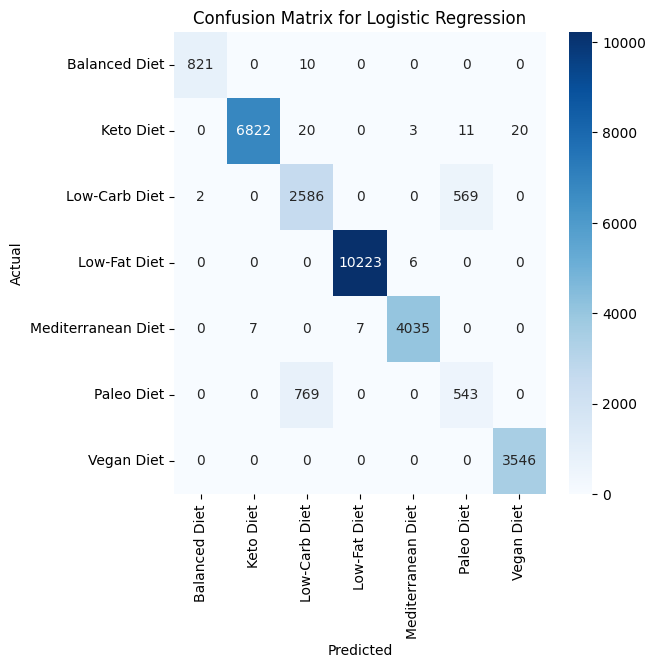


Training Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy of Random Forest: 0.9551
Classification Report for Random Forest:
                    precision    recall  f1-score   support

     Balanced Diet       1.00      1.00      1.00       831
         Keto Diet       1.00      1.00      1.00      6876
     Low-Carb Diet       0.78      0.79      0.79      3157
      Low-Fat Diet       1.00      1.00      1.00     10229
Mediterranean Diet       1.00      1.00      1.00      4049
        Paleo Diet       0.49      0.47      0.48      1312
        Vegan Diet       1.00      1.00      1.00      3546

          accuracy                           0.96     30000
         macro avg       0.90      0.90      0.90     30000
      weighted avg       0.95      0.96      0.95     30000



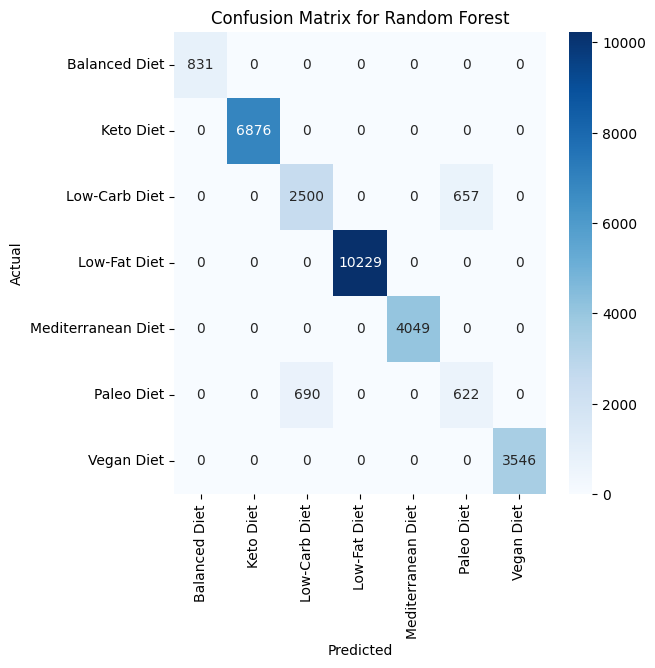


Training Support Vector Classifier...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for Support Vector Classifier: {'C': 10, 'kernel': 'linear'}
Accuracy of Support Vector Classifier: 0.9557
Classification Report for Support Vector Classifier:
                    precision    recall  f1-score   support

     Balanced Diet       1.00      1.00      1.00       831
         Keto Diet       1.00      0.99      1.00      6876
     Low-Carb Diet       0.84      0.73      0.78      3157
      Low-Fat Diet       1.00      1.00      1.00     10229
Mediterranean Diet       1.00      1.00      1.00      4049
        Paleo Diet       0.51      0.68      0.58      1312
        Vegan Diet       0.99      1.00      1.00      3546

          accuracy                           0.96     30000
         macro avg       0.91      0.91      0.91     30000
      weighted avg       0.96      0.96      0.96     30000



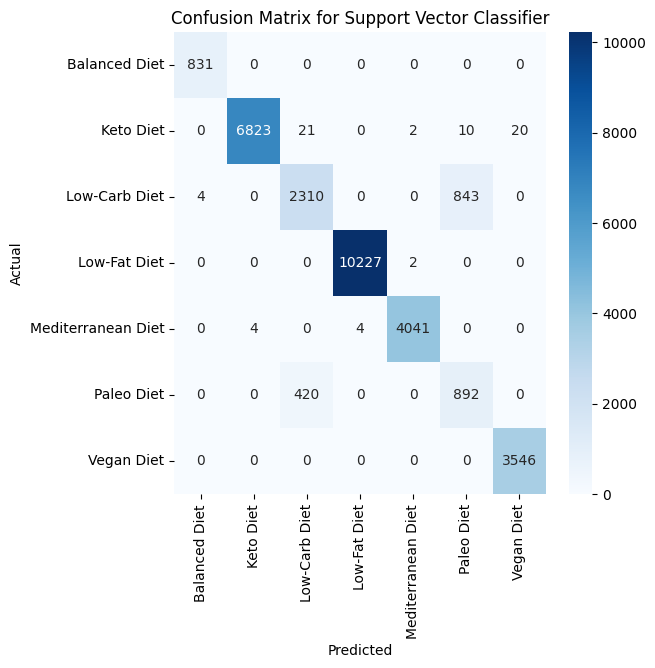


Training K-Nearest Neighbors...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for K-Nearest Neighbors: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy of K-Nearest Neighbors: 0.9472
Classification Report for K-Nearest Neighbors:
                    precision    recall  f1-score   support

     Balanced Diet       0.96      0.94      0.95       831
         Keto Diet       1.00      0.99      0.99      6876
     Low-Carb Diet       0.76      0.79      0.77      3157
      Low-Fat Diet       1.00      1.00      1.00     10229
Mediterranean Diet       0.99      0.98      0.99      4049
        Paleo Diet       0.49      0.47      0.48      1312
        Vegan Diet       0.99      1.00      1.00      3546

          accuracy                           0.95     30000
         macro avg       0.88      0.88      0.88     30000
      weighted avg       0.95      0.95      0.95     30000



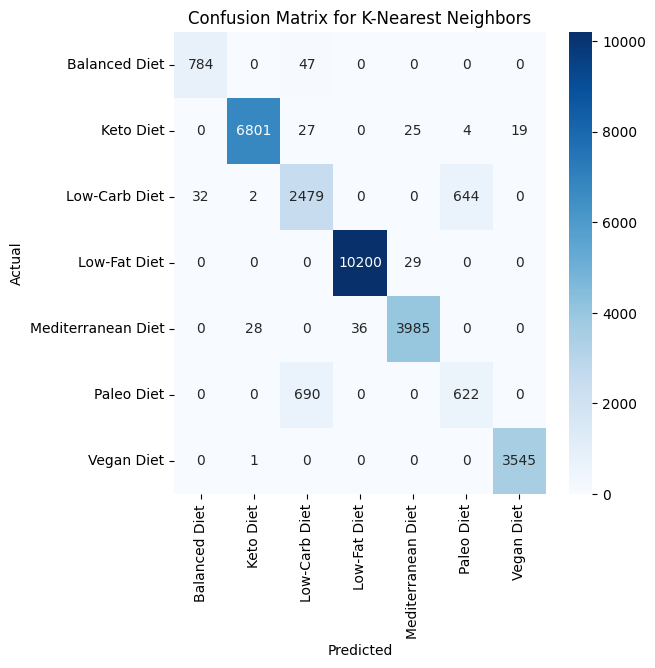


Training Gradient Boosting Classifier...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define models and their parameter grids
models = {
    "Logistic Regression": {
        "model": LogisticRegression(),
        "param_grid": {
            "C": [0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [10, 20, None],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Support Vector Classifier": {
        "model": SVC(),
        "param_grid": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "Gradient Boosting Classifier": {
        "model": GradientBoostingClassifier(),
        "param_grid": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "param_grid": {}  # No hyperparameters to tune for GaussianNB
    }
}

# Train, tune, and evaluate each model
for model_name, model_info in models.items():
    print(f"\nTraining {model_name}...")

    # Grid search for hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model_info["model"],
        param_grid=model_info["param_grid"],
        cv=3,
        n_jobs=-1,
        verbose=2
    ) if model_info["param_grid"] else model_info["model"]  # Skip GridSearch for models without hyperparameters

    if model_info["param_grid"]:
        grid_search.fit(x_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    else:
        best_model = model_info["model"]
        best_model.fit(x_train, y_train)

    # Predictions
    y_pred = best_model.predict(x_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {model_name}: {accuracy:.4f}")

    # Classification report
    print(f"Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}")

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


gbc = GradientBoostingClassifier(n_estimators=300,
                                 learning_rate=0.05,
                                 random_state=100,
                                 max_features=5 )


# Fit to training set
gbc.fit(x_train, y_train)
 
# Predict on test set
pred_y = gbc.predict(x_test)
 
# accuracy
acc = accuracy_score(y_test, pred_y)
print("Gradient Boosting Classifier accuracy is : {:.2f}".format(acc))

Gradient Boosting Classifier accuracy is : 0.95
